# ECE 662 Mini Project 2
## Jiadao Zou (Wong Jun Hua)

In [1]:
from sklearn.datasets import make_gaussian_quantiles
import pandas
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import *
import operator
import prettytable
from scipy.stats import kde

In [2]:
def bayes_classifier(x_vec, kdes):
    """
    Classifies an input sample into class w_j determined by
    maximizing the class conditional probability for p(x|w_j).

    Keyword arguments:
        x_vec: A dx1 dimensional numpy array representing the sample.
        kdes: List of the gausssian_kde (kernel density) estimates

    Returns a tuple ( p(x|w_j)_value, class label ).

    """
    p_vals = []
    for kde in kdes:
        p_vals.append(kde.evaluate(x_vec))
    max_index, max_value = max(enumerate(p_vals), key=operator.itemgetter(1))
    return (max_value, max_index + 1)


def empirical_error(data_set, classes, classifier_func, classifier_func_args):
    """
    Keyword arguments:
        data_set: 'n x d'- dimensional numpy array, class label in the last column.
        classes: List of the class labels.
        classifier_func: Function that returns the max argument from the discriminant function.
            evaluation and the class label as a tuple.
        classifier_func_args: List of arguments for the 'classifier_func'.

    Returns a tuple, consisting of a dictionary withthe classif. counts and the error.

    e.g., ( {1: {1: 321, 2: 5}, 2: {1: 0, 2: 317}}, 0.05)
    where keys are class labels, and values are sub-dicts counting for which class (key)
    how many samples where classified as such.

    """
    class_dict = {i: {j: 0 for j in classes} for i in classes}

    for cl in classes:
        for row in data_set[data_set[:, -1] == cl][:, :-1]:
            g = classifier_func(row, *classifier_func_args)
            class_dict[cl][g[1]] += 1

    correct = 0
    for i in classes:
        correct += class_dict[i][i]

    misclass = data_set.shape[0] - correct
    return (class_dict, misclass / data_set.shape[0])


## Task 1 Data generation method: Consider N-dimensional feature vectors coming from C classes. Assume that the distributions of the feature vectors for the two classes are (known) normal distributions (with same priors).

- Define different parzen window size

In [3]:
window_bw = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# Initialize array to store the error rate for different dimensions, N
emp_error_2n_2c = []
emp_error_3n_2c = []
emp_error_4n_2c = []
emp_error_5n_2c = []

### 1.1: C=2, 80 samples for each class (40 for training, 40 for testing): Evaluate and plot error rate (@ testing data) for varying Parzen window sizes   (consider at least 4 different dimension : N) 



#### 2 dimensional for 2 different classes

In [4]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(2)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 0], [3, 0], [4, 5]]):
    mu_vecs[i] = array(j).reshape(2, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 3):
    # generating 80x3 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)

assert(train_set.shape == (80, 3))
assert(test_set.shape == (80, 3))

for bw in window_bw:
    class1_kde = kde.gaussian_kde(train_set[train_set[:,2] == 1].T[0:2], bw_method=bw)
    class2_kde = kde.gaussian_kde(train_set[train_set[:,2] == 2].T[0:2], bw_method=bw)

    classification_dict, error = empirical_error(test_set, [1,2,3], bayes_classifier,
                                 [[class1_kde, class2_kde]])

    labels_predicted = ['w{} (predicted)'.format(i) for i in [1,2]]
    labels_predicted.insert(0,'test dataset')

    train_conf_mat = prettytable.PrettyTable(labels_predicted)
    for i in [1, 2]:
        a, b = [classification_dict[i][j] for j in [1, 2]]
        # workaround to unpack (since Python does not support just '*a')
        train_conf_mat.add_row(['w{} (actual)'.format(i), a, b])
    print(train_conf_mat)
    print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))
    emp_error_2n_2c.append(error)

+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       29       |       11       |
| w2 (actual)  |       1        |       39       |
+--------------+----------------+----------------+
Empirical Error: 0.15 (15.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       31       |       9        |
| w2 (actual)  |       2        |       38       |
+--------------+----------------+----------------+
Empirical Error: 0.14 (13.75%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       35       |       5        |
| w2 (actual)  |       1        |       39       |
+--------------+----------------+----------------+
Empirical Error: 0.0

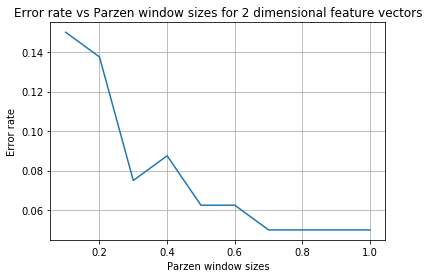

In [5]:
# Plots of the graphs
# First plot, 2 dimensional for 2 classes
fig = plt.figure()

plt.plot(window_bw, emp_error_2n_2c)
plt.title('Error rate vs Parzen window sizes for 2 dimensional feature vectors')
plt.xlabel('Parzen window sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()

#### 3 dimensional for 2 different classes

In [6]:
# Covariance matrices
cov_mats = {}
for i in range(1,3):
    cov_mats[i] = i * eye(3)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 0, 0], [3, 0, 3], [4, 5, 4]]):
    mu_vecs[i] = array(j).reshape(3, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 3):
    # generating 80x4 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)

test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)

assert(train_set.shape == (80, 4))
assert(test_set.shape == (80, 4))

for bw in window_bw:
    class1_kde = kde.gaussian_kde(train_set[train_set[:, 3] == 1].T[0:3], bw_method=bw)
    class2_kde = kde.gaussian_kde(train_set[train_set[:, 3] == 2].T[0:3], bw_method=bw)

    classification_dict, error = empirical_error(test_set, [1, 2, 3], bayes_classifier,
                                 [[class1_kde, class2_kde]])

    labels_predicted = ['w{} (predicted)'.format(i) for i in [1,2]]
    labels_predicted.insert(0,'test dataset')

    train_conf_mat = prettytable.PrettyTable(labels_predicted)
    for i in [1, 2]:
        a, b = [classification_dict[i][j] for j in [1, 2]]
        # workaround to unpack (since Python does not support just '*a')
        train_conf_mat.add_row(['w{} (actual)'.format(i), a, b])
    print(train_conf_mat)
    print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))
    emp_error_3n_2c.append(error)

+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       38       |       2        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.03 (2.50%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       38       |       2        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.03 (2.50%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       38       |       2        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.03 

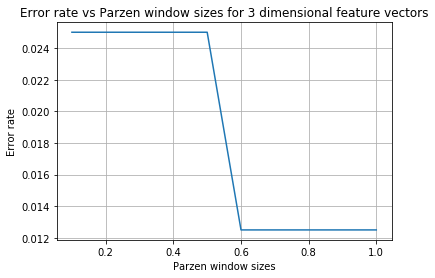

In [7]:
# Second plot, 3 dimensional for 2 classes
fig = plt.figure()

plt.plot(window_bw, emp_error_3n_2c)
plt.title('Error rate vs Parzen window sizes for 3 dimensional feature vectors')
plt.xlabel('Parzen window sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()

#### 4 dimensional for 2 classes

In [8]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(4)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[1, 1, 0, 7], [3, 8, 3, 1], [4, 5, 9, 6]]):
    mu_vecs[i] = array(j).reshape(4, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 3):
    # generating 80x4 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)

assert(train_set.shape == (80, 5))
assert(test_set.shape == (80, 5))

for bw in window_bw:
    class1_kde = kde.gaussian_kde(train_set[train_set[:, 4] == 1].T[0:4], bw_method=bw)
    class2_kde = kde.gaussian_kde(train_set[train_set[:, 4] == 2].T[0:4], bw_method=bw)

    classification_dict, error = empirical_error(test_set, [1, 2, 3], bayes_classifier,
                                 [[class1_kde, class2_kde]])

    labels_predicted = ['w{} (predicted)'.format(i) for i in [1, 2]]
    labels_predicted.insert(0, 'test dataset')

    train_conf_mat = prettytable.PrettyTable(labels_predicted)
    for i in [1, 2]:
        a, b = [classification_dict[i][j] for j in [1, 2]]
        # workaround to unpack (since Python does not support just '*a')
        train_conf_mat.add_row(['w{} (actual)'.format(i), a, b])
    print(train_conf_mat)
    print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))
    emp_error_4n_2c.append(error)

+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       40       |       0        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.00 (0.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       40       |       0        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.00 (0.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       40       |       0        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.00 

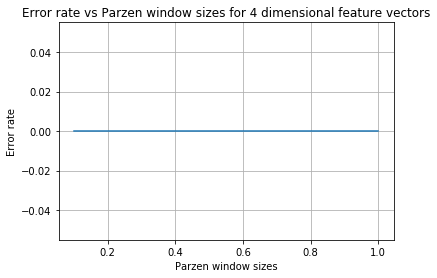

In [9]:
# Third plot, 4 dimensional for 2 classes
fig = plt.figure()

plt.plot(window_bw, emp_error_4n_2c)
plt.title('Error rate vs Parzen window sizes for 4 dimensional feature vectors')
plt.xlabel('Parzen window sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()

#### 5 dimensional for 2 classes

In [10]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(5)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 1, 0, 7, 6], [3, 0, 3, 1, 6], [4, 5, 4, 6, 7]]):
    mu_vecs[i] = array(j).reshape(5, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 3):
    # generating 80x4 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to last column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)

assert(train_set.shape == (80, 6))
assert(test_set.shape == (80, 6))

for bw in window_bw:
    class1_kde = kde.gaussian_kde(train_set[train_set[:, 5] == 1].T[0:5], bw_method=bw)
    class2_kde = kde.gaussian_kde(train_set[train_set[:, 5] == 2].T[0:5], bw_method=bw)

    classification_dict, error = empirical_error(test_set, [1, 2, 3], bayes_classifier,
                                 [[class1_kde, class2_kde]])

    labels_predicted = ['w{} (predicted)'.format(i) for i in [1, 2]]
    labels_predicted.insert(0, 'test dataset')

    train_conf_mat = prettytable.PrettyTable(labels_predicted)
    for i in [1, 2]:
        a, b = [classification_dict[i][j] for j in [1, 2]]
        # workaround to unpack (since Python does not support just '*a')
        train_conf_mat.add_row(['w{} (actual)'.format(i), a, b])
    print(train_conf_mat)
    print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))
    emp_error_5n_2c.append(error)

+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       40       |       0        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.00 (0.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       40       |       0        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.00 (0.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       40       |       0        |
| w2 (actual)  |       0        |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.00 

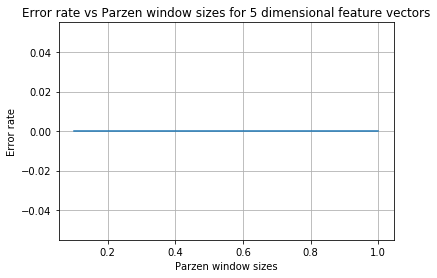

In [11]:
# Last plot, 5 dimensional for 2 classes
fig = plt.figure()

plt.plot(window_bw, emp_error_5n_2c)
plt.title('Error rate vs Parzen window sizes for 5 dimensional feature vectors')
plt.xlabel('Parzen window sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()


### 1.3: C=5, N =2, 80 samples for each class (40 for training, 40 for testing): plot error rate (@ testing data) for varying Parzen window sizes to analyze the best window size 

+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       34       |       6        |
| w2 (actual)  |       8        |       32       |
+--------------+----------------+----------------+
Empirical Error: 0.67 (67.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       34       |       6        |
| w2 (actual)  |       8        |       32       |
+--------------+----------------+----------------+
Empirical Error: 0.67 (67.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       36       |       4        |
| w2 (actual)  |       9        |       31       |
+--------------+----------------+----------------+
Empirical Error: 0.6

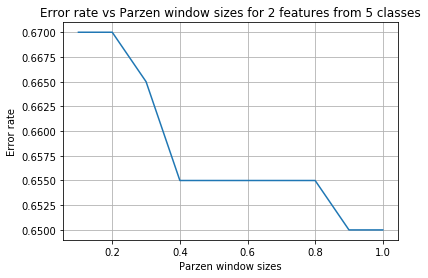

In [12]:
indow_bw = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Initialize array to store the error rate for different dimensions, N
emp_error = []

#########################################################################
# 2 dimensional for 5 different classes

# Covariance matrices
cov_mats = {}
for i in range(1, 6):
    cov_mats[i] = i * eye(2)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 6), [[0, 0], [3, 0], [4, 5], [3, 6], [7, 3]]):
    mu_vecs[i] = array(j).reshape(2, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 6):
    # generating 80x5 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
train_set = append(train_set, all_samples[3][0:40], axis=0)
train_set = append(train_set, all_samples[4][0:40], axis=0)
train_set = append(train_set, all_samples[5][0:40], axis=0)

test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)
test_set = append(test_set, all_samples[3][40:80], axis=0)
test_set = append(test_set, all_samples[4][40:80], axis=0)
test_set = append(test_set, all_samples[5][40:80], axis=0)

# 40 for training and 40 for testing for each class, thus training data and testing data should have
# size of (40 * 5 = 200, 3) shape, last column is the class column
assert(train_set.shape == (200, 3))
assert(test_set.shape == (200, 3))

for bw in window_bw:
    class1_kde = kde.gaussian_kde(train_set[train_set[:,2] == 1].T[0:2], bw_method=bw)
    class2_kde = kde.gaussian_kde(train_set[train_set[:,2] == 2].T[0:2], bw_method=bw)

    classification_dict, error = empirical_error(test_set, [1,2], bayes_classifier,
                                 [[class1_kde, class2_kde]])

    labels_predicted = ['w{} (predicted)'.format(i) for i in [1,2]]
    labels_predicted.insert(0,'test dataset')

    train_conf_mat = prettytable.PrettyTable(labels_predicted)
    for i in [1, 2]:
        a, b = [classification_dict[i][j] for j in [1, 2]]
        # workaround to unpack (since Python does not support just '*a')
        train_conf_mat.add_row(['w{} (actual)'.format(i), a, b])
    print(train_conf_mat)
    print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))
    emp_error.append(error)

#########################################################################
# Plots of the graphs
# First plot, 2 dimensional for 5 classes
fig = plt.figure()

plt.plot(window_bw, emp_error)
plt.title('Error rate vs Parzen window sizes for 2 features from 5 classes')
plt.xlabel('Parzen window sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()


### 1.4: Analyze how # of training samples (e.g., from 10 to 10k)  impact the error rate (@ testing data), with different dimension: N. You can choose other parameters based on your own need

In [13]:
training_samples = [10, 50, 100, 500, 1000, 5000, 10000]

# Initialize array to store the error rate for different dimensions, N
emp_error_2n = []
emp_error_3n = []
emp_error_4n = []

#### 2 dimensional for 2 different classes

In [14]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(2)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 0], [3, 0]]):
    mu_vecs[i] = array(j).reshape(2, 1)

# Generating the random samples
for train_size in training_samples:
    all_samples = {}
    for i in range(1, 3):
        # generating 80x3 dimensional arrays with random Gaussian-distributed samples
        class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], train_size)
        # adding class label to 3rd column
        class_samples = append(class_samples, zeros((train_size, 1))+i, axis=1)
        all_samples[i] = class_samples

    # Dividing the samples into training and test datasets, half for train and testing
    train_set = append(all_samples[1][0:int((train_size/2))], all_samples[2][0:(int(train_size/2))], axis=0)
    test_set = append(all_samples[1][int((train_size/2)):int(train_size)], all_samples[2][int((train_size/2)):
                                                                                             int(train_size)], axis=0)

    assert(train_set.shape == (train_size, 3))
    assert(test_set.shape == (train_size, 3))

    class1_kde = kde.gaussian_kde(train_set[train_set[:,2] == 1].T[0:2], bw_method='scott')
    class2_kde = kde.gaussian_kde(train_set[train_set[:,2] == 2].T[0:2], bw_method='scott')

    classification_dict, error = empirical_error(test_set, [1, 2], bayes_classifier,
                                 [[class1_kde, class2_kde]])

    labels_predicted = ['w{} (predicted)'.format(i) for i in [1,2]]
    labels_predicted.insert(0, 'test dataset')

    train_conf_mat = prettytable.PrettyTable(labels_predicted)
    for i in [1, 2]:
        a, b = [classification_dict[i][j] for j in [1, 2]]
        # workaround to unpack (since Python does not support just '*a')
        train_conf_mat.add_row(['w{} (actual)'.format(i), a, b])
    print(train_conf_mat)
    print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))
    emp_error_2n.append(error)

+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       3        |       2        |
| w2 (actual)  |       0        |       5        |
+--------------+----------------+----------------+
Empirical Error: 0.20 (20.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       25       |       0        |
| w2 (actual)  |       4        |       21       |
+--------------+----------------+----------------+
Empirical Error: 0.08 (8.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       44       |       6        |
| w2 (actual)  |       10       |       40       |
+--------------+----------------+----------------+
Empirical Error: 0.16

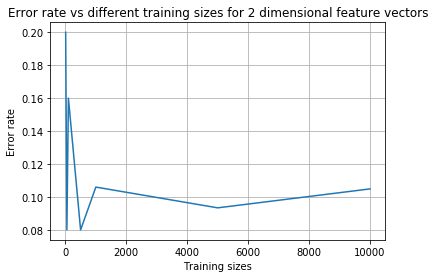

In [15]:
#########################################################################
# Plots of the graphs
# First plot, 2 dimensional for 2 classes
fig = plt.figure()

plt.plot(training_samples, emp_error_2n)
plt.title('Error rate vs different training sizes for 2 dimensional feature vectors')
plt.xlabel('Training sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()


#### 3 dimensional for 2 different classes

In [16]:
# Covariance matrices
cov_mats = {}
for i in range(1,3):
    cov_mats[i] = i * eye(3)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 0, 0], [3, 0, 3]]):
    mu_vecs[i] = array(j).reshape(3, 1)

for train_size in training_samples:
    all_samples = {}
    for i in range(1, 3):
        # generating 80x3 dimensional arrays with random Gaussian-distributed samples
        class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], train_size)
        # adding class label to 3rd column
        class_samples = append(class_samples, zeros((train_size, 1))+i, axis=1)
        all_samples[i] = class_samples

    # Dividing the samples into training and test datasets, half for train and testing
    train_set = append(all_samples[1][0:int((train_size/2))], all_samples[2][0:(int(train_size/2))], axis=0)
    test_set = append(all_samples[1][int((train_size/2)):int(train_size)], all_samples[2][int((train_size/2)):
                                                                                             int(train_size)], axis=0)

    assert(train_set.shape == (train_size, 4))
    assert(test_set.shape == (train_size, 4))

    class1_kde = kde.gaussian_kde(train_set[train_set[:, 3] == 1].T[0:3], bw_method='scott')
    class2_kde = kde.gaussian_kde(train_set[train_set[:, 3] == 2].T[0:3], bw_method='scott')

    classification_dict, error = empirical_error(test_set, [1, 2], bayes_classifier,
                                 [[class1_kde, class2_kde]])

    labels_predicted = ['w{} (predicted)'.format(i) for i in [1, 2]]
    labels_predicted.insert(0, 'test dataset')

    train_conf_mat = prettytable.PrettyTable(labels_predicted)
    for i in [1, 2]:
        a, b = [classification_dict[i][j] for j in [1, 2]]
        # workaround to unpack (since Python does not support just '*a')
        train_conf_mat.add_row(['w{} (actual)'.format(i), a, b])
    print(train_conf_mat)
    print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))
    emp_error_3n.append(error)

+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       5        |       0        |
| w2 (actual)  |       0        |       5        |
+--------------+----------------+----------------+
Empirical Error: 0.00 (0.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       25       |       0        |
| w2 (actual)  |       1        |       24       |
+--------------+----------------+----------------+
Empirical Error: 0.02 (2.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       48       |       2        |
| w2 (actual)  |       4        |       46       |
+--------------+----------------+----------------+
Empirical Error: 0.06 

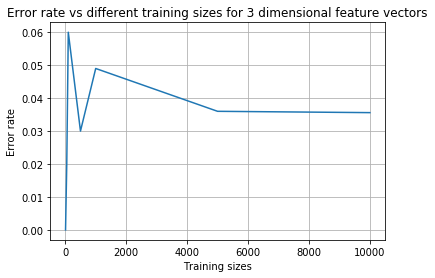

In [17]:
# Second plot, 3 dimensional for 2 classes
fig = plt.figure()

plt.plot(training_samples, emp_error_3n)
plt.title('Error rate vs different training sizes for 3 dimensional feature vectors')
plt.xlabel('Training sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()

#### 4 dimensional for 2 classes

In [18]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(4)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[1, 1, 0, 7], [3, 8, 3, 1], [4, 5, 9, 6]]):
    mu_vecs[i] = array(j).reshape(4, 1)

for train_size in training_samples:
    all_samples = {}
    for i in range(1, 3):
        # generating 80x3 dimensional arrays with random Gaussian-distributed samples
        class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], train_size)
        # adding class label to 3rd column
        class_samples = append(class_samples, zeros((train_size, 1))+i, axis=1)
        all_samples[i] = class_samples

    # Dividing the samples into training and test datasets, half for train and testing
    train_set = append(all_samples[1][0:int((train_size/2))], all_samples[2][0:(int(train_size/2))], axis=0)
    test_set = append(all_samples[1][int((train_size/2)):int(train_size)], all_samples[2][int((train_size/2)):
                                                                                             int(train_size)], axis=0)

    assert(train_set.shape == (train_size, 5))
    assert(test_set.shape == (train_size, 5))

    class1_kde = kde.gaussian_kde(train_set[train_set[:, 4] == 1].T[0:4], bw_method='scott')
    class2_kde = kde.gaussian_kde(train_set[train_set[:, 4] == 2].T[0:4], bw_method='scott')

    classification_dict, error = empirical_error(test_set, [1, 2], bayes_classifier,
                                 [[class1_kde, class2_kde]])

    labels_predicted = ['w{} (predicted)'.format(i) for i in [1, 2]]
    labels_predicted.insert(0, 'test dataset')

    train_conf_mat = prettytable.PrettyTable(labels_predicted)
    for i in [1, 2]:
        a, b = [classification_dict[i][j] for j in [1, 2]]
        # workaround to unpack (since Python does not support just '*a')
        train_conf_mat.add_row(['w{} (actual)'.format(i), a, b])
    print(train_conf_mat)
    print('Empirical Error: {:.2f} ({:.2f}%)'.format(error, error * 100))
    emp_error_4n.append(error)

+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       5        |       0        |
| w2 (actual)  |       0        |       5        |
+--------------+----------------+----------------+
Empirical Error: 0.00 (0.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       25       |       0        |
| w2 (actual)  |       0        |       25       |
+--------------+----------------+----------------+
Empirical Error: 0.00 (0.00%)
+--------------+----------------+----------------+
| test dataset | w1 (predicted) | w2 (predicted) |
+--------------+----------------+----------------+
| w1 (actual)  |       50       |       0        |
| w2 (actual)  |       0        |       50       |
+--------------+----------------+----------------+
Empirical Error: 0.00 

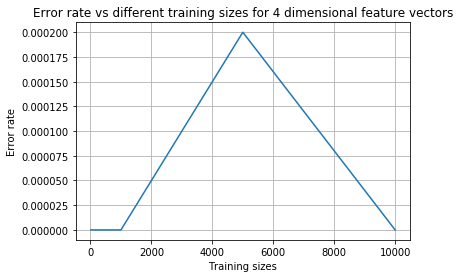

In [19]:
# Third plot, 4 dimensional for 2 classes
fig = plt.figure()

plt.plot(training_samples, emp_error_4n)
plt.title('Error rate vs different training sizes for 4 dimensional feature vectors')
plt.xlabel('Training sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()

## Task 2, study the KNN

- Define different K

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

k_range = [1, 2, 3, 5, 10, 20]
# Initialize array to store the error rate for different dimensions, N
emp_error_2n_2c = []
emp_error_3n_2c = []
emp_error_4n_2c = []
emp_error_5n_2c = []

### 2.1: C=2, 80 samples for each class (40 for training, 40 for testing): Evaluate and plot error rate (@ testing data) for varying K   (consider at least 4 different dimension : N )

#### 2 dimensional for 2 different classes

##############################################################################
when k is 1  !
Test set accuracy: 85.00%
##############################################################################
when k is 2  !
Test set accuracy: 86.25%
##############################################################################
when k is 3  !
Test set accuracy: 87.50%
##############################################################################
when k is 5  !
Test set accuracy: 87.50%
##############################################################################
when k is 10  !
Test set accuracy: 90.00%
##############################################################################
when k is 20  !
Test set accuracy: 90.00%


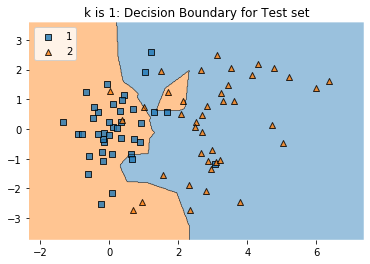

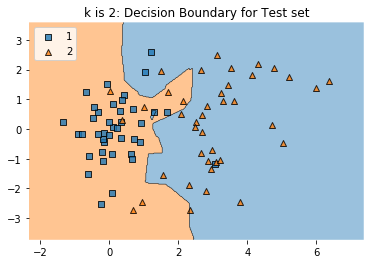

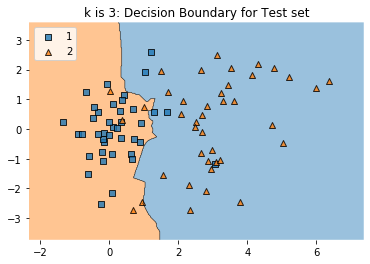

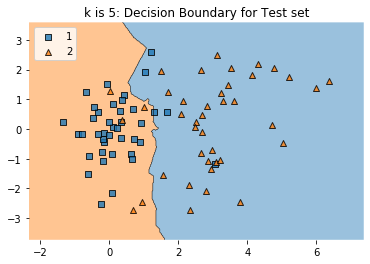

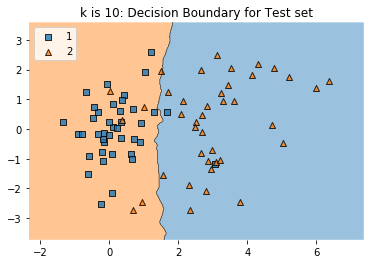

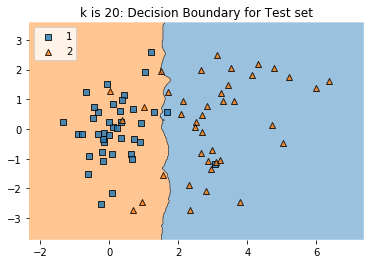

In [21]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(2)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 0], [3, 0], [4, 5]]):
    mu_vecs[i] = array(j).reshape(2, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 3):
    # generating 80x3 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)

assert(train_set.shape == (80, 3))
assert(test_set.shape == (80, 3))

X_train = train_set[:, :-1]
X_test = test_set[:, :-1]
y_train = train_set[:, -1].astype(integer)
y_test = test_set[:, -1].astype(integer)


for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    accuracy = (num_correct_predictions / y_test.shape[0]) * 100
    print('##############################################################################')
    print(f"when k is {k}  !")
    print('Test set accuracy: %.2f%%' % accuracy)
    
    
    plot_decision_regions(X_test, y_test, knn_model)
    plt.legend(loc='upper left')
    plt.title(f'k is {k}: Decision Boundary for Test set')
    plt.show()

#### 3 dimensional for 2 different classes

In [22]:
# Covariance matrices
cov_mats = {}
for i in range(1,3):
    cov_mats[i] = i * eye(3)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 0, 0], [3, 0, 3], [4, 5, 4]]):
    mu_vecs[i] = array(j).reshape(3, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 3):
    # generating 80x4 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)

test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)

assert(train_set.shape == (80, 4))
assert(test_set.shape == (80, 4))

X_train = train_set[:, :-1]
X_test = test_set[:, :-1]
y_train = train_set[:, -1]
y_test = test_set[:, -1].astype(integer)

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    accuracy = (num_correct_predictions / y_test.shape[0]) * 100
    print('##############################################################################')
    print(f"when k is {k}  !")
    print('Test set accuracy: %.2f%%' % accuracy)
    

##############################################################################
when k is 1  !
Test set accuracy: 91.25%
##############################################################################
when k is 2  !
Test set accuracy: 90.00%
##############################################################################
when k is 3  !
Test set accuracy: 90.00%
##############################################################################
when k is 5  !
Test set accuracy: 91.25%
##############################################################################
when k is 10  !
Test set accuracy: 93.75%
##############################################################################
when k is 20  !
Test set accuracy: 93.75%


#### 4 dimensional for 2 classes

In [23]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(4)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[1, 1, 0, 7], [3, 8, 3, 1], [4, 5, 9, 6]]):
    mu_vecs[i] = array(j).reshape(4, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 3):
    # generating 80x4 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)

assert(train_set.shape == (80, 5))
assert(test_set.shape == (80, 5))

X_train = train_set[:, :-1]
X_test = test_set[:, :-1]
y_train = train_set[:, -1]
y_test = test_set[:, -1].astype(integer)

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    accuracy = (num_correct_predictions / y_test.shape[0]) * 100
    print('##############################################################################')
    print(f"when k is {k}  !")
    print('Test set accuracy: %.2f%%' % accuracy)

##############################################################################
when k is 1  !
Test set accuracy: 100.00%
##############################################################################
when k is 2  !
Test set accuracy: 100.00%
##############################################################################
when k is 3  !
Test set accuracy: 100.00%
##############################################################################
when k is 5  !
Test set accuracy: 100.00%
##############################################################################
when k is 10  !
Test set accuracy: 100.00%
##############################################################################
when k is 20  !
Test set accuracy: 100.00%


#### 5 dimensional for 2 classes

In [24]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(5)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 1, 0, 7, 6], [3, 0, 3, 1, 6], [4, 5, 4, 6, 7]]):
    mu_vecs[i] = array(j).reshape(5, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 3):
    # generating 80x4 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to last column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)

assert(train_set.shape == (80, 6))
assert(test_set.shape == (80, 6))

X_train = train_set[:, :-1]
X_test = test_set[:, :-1]
y_train = train_set[:, -1]
y_test = test_set[:, -1].astype(integer)

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    accuracy = (num_correct_predictions / y_test.shape[0]) * 100
    print('##############################################################################')
    print(f"when k is {k}  !")
    print('Test set accuracy: %.2f%%' % accuracy)

##############################################################################
when k is 1  !
Test set accuracy: 100.00%
##############################################################################
when k is 2  !
Test set accuracy: 100.00%
##############################################################################
when k is 3  !
Test set accuracy: 100.00%
##############################################################################
when k is 5  !
Test set accuracy: 100.00%
##############################################################################
when k is 10  !
Test set accuracy: 100.00%
##############################################################################
when k is 20  !
Test set accuracy: 100.00%


 
### 2.3 C=5, N = 2, 80 samples for each class (40 for training, 40 for testing): plot error rate  (@ testing data) for varying K to analyze the best K
- Actually, we have done this before.

In [25]:
# Covariance matrices
cov_mats = {}
for i in range(1, 6):
    cov_mats[i] = i * eye(2)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 6), [[0, 0], [3, 0], [4, 5], [3, 6], [7, 3]]):
    mu_vecs[i] = array(j).reshape(2, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 6):
    # generating 80x5 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
train_set = append(train_set, all_samples[3][0:40], axis=0)
train_set = append(train_set, all_samples[4][0:40], axis=0)
train_set = append(train_set, all_samples[5][0:40], axis=0)

test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)
test_set = append(test_set, all_samples[3][40:80], axis=0)
test_set = append(test_set, all_samples[4][40:80], axis=0)
test_set = append(test_set, all_samples[5][40:80], axis=0)

# 40 for training and 40 for testing for each class, thus training data and testing data should have
# size of (40 * 5 = 200, 3) shape, last column is the class column
assert(train_set.shape == (200, 3))
assert(test_set.shape == (200, 3))

X_train = train_set[:, :-1]
X_test = test_set[:, :-1]
y_train = train_set[:, -1]
y_test = test_set[:, -1].astype(integer)

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    accuracy = (num_correct_predictions / y_test.shape[0]) * 100
    print('##############################################################################')
    print(f"when k is {k}  !")
    print('Test set accuracy: %.2f%%' % accuracy)
    

##############################################################################
when k is 1  !
Test set accuracy: 60.50%
##############################################################################
when k is 2  !
Test set accuracy: 62.00%
##############################################################################
when k is 3  !
Test set accuracy: 63.50%
##############################################################################
when k is 5  !
Test set accuracy: 66.00%
##############################################################################
when k is 10  !
Test set accuracy: 66.00%
##############################################################################
when k is 20  !
Test set accuracy: 71.00%


#### 2.4 Analyze how # of training samples (e.g., from 10 to 10k) impact the error rate (@ testing data), with different dimension: N. You can choose other parameters based on your own need.
- Now, we fix K as 5

In [26]:
training_samples = [10, 50, 100, 500, 1000, 5000, 10000]
k = 5
# Initialize array to store the error rate for different dimensions, N
emp_error_2n = []
emp_error_3n = []
emp_error_4n = []

#### 2 dimensional for 2 different classes

In [27]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(2)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 0], [3, 0]]):
    mu_vecs[i] = array(j).reshape(2, 1)

# Generating the random samples
for train_size in training_samples:
    all_samples = {}
    for i in range(1, 3):
        # generating 80x3 dimensional arrays with random Gaussian-distributed samples
        class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], train_size)
        # adding class label to 3rd column
        class_samples = append(class_samples, zeros((train_size, 1))+i, axis=1)
        all_samples[i] = class_samples

    # Dividing the samples into training and test datasets, half for train and testing
    train_set = append(all_samples[1][0:int((train_size/2))], all_samples[2][0:(int(train_size/2))], axis=0)
    test_set = append(all_samples[1][int((train_size/2)):int(train_size)], all_samples[2][int((train_size/2)):
                                                                                             int(train_size)], axis=0)

    assert(train_set.shape == (train_size, 3))
    assert(test_set.shape == (train_size, 3))

    X_train = train_set[:, :-1]
    X_test = test_set[:, :-1]
    y_train = train_set[:, -1]
    y_test = test_set[:, -1].astype(integer)
    
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    error = (1-(num_correct_predictions / y_test.shape[0])) * 100

    emp_error_2n.append(error)

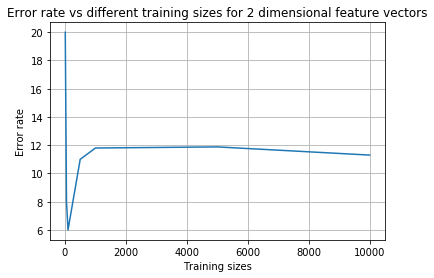

In [28]:
#########################################################################
# Plots of the graphs
# First plot, 2 dimensional for 2 classes
fig = plt.figure()

plt.plot(training_samples, emp_error_2n)
plt.title('Error rate vs different training sizes for 2 dimensional feature vectors')
plt.xlabel('Training sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()


#### 3 dimensional for 2 different classes

In [29]:
# Covariance matrices
cov_mats = {}
for i in range(1,3):
    cov_mats[i] = i * eye(3)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[0, 0, 0], [3, 0, 3]]):
    mu_vecs[i] = array(j).reshape(3, 1)

for train_size in training_samples:
    all_samples = {}
    for i in range(1, 3):
        # generating 80x3 dimensional arrays with random Gaussian-distributed samples
        class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], train_size)
        # adding class label to 3rd column
        class_samples = append(class_samples, zeros((train_size, 1))+i, axis=1)
        all_samples[i] = class_samples

    # Dividing the samples into training and test datasets, half for train and testing
    train_set = append(all_samples[1][0:int((train_size/2))], all_samples[2][0:(int(train_size/2))], axis=0)
    test_set = append(all_samples[1][int((train_size/2)):int(train_size)], all_samples[2][int((train_size/2)):
                                                                                             int(train_size)], axis=0)

    assert(train_set.shape == (train_size, 4))
    assert(test_set.shape == (train_size, 4))

    X_train = train_set[:, :-1]
    X_test = test_set[:, :-1]
    y_train = train_set[:, -1]
    y_test = test_set[:, -1].astype(integer)
    
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    error = (1-(num_correct_predictions / y_test.shape[0])) * 100

    emp_error_3n.append(error)

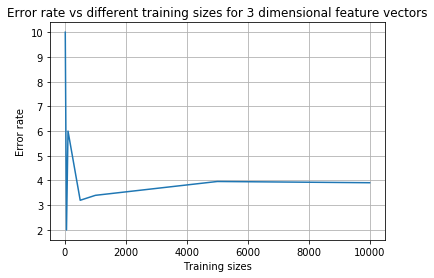

In [30]:
#########################################################################
# Plots of the graphs
# First plot, 3 dimensional for 2 classes
fig = plt.figure()

plt.plot(training_samples, emp_error_3n)
plt.title('Error rate vs different training sizes for 3 dimensional feature vectors')
plt.xlabel('Training sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()

#### 4 dimensional for 2 classes

In [31]:
# Covariance matrices
cov_mats = {}
for i in range(1, 3):
    cov_mats[i] = i * eye(4)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 3), [[1, 1, 0, 7], [3, 8, 3, 1], [4, 5, 9, 6]]):
    mu_vecs[i] = array(j).reshape(4, 1)

for train_size in training_samples:
    all_samples = {}
    for i in range(1, 3):
        # generating 80x3 dimensional arrays with random Gaussian-distributed samples
        class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], train_size)
        # adding class label to 3rd column
        class_samples = append(class_samples, zeros((train_size, 1))+i, axis=1)
        all_samples[i] = class_samples

    # Dividing the samples into training and test datasets, half for train and testing
    train_set = append(all_samples[1][0:int((train_size/2))], all_samples[2][0:(int(train_size/2))], axis=0)
    test_set = append(all_samples[1][int((train_size/2)):int(train_size)], all_samples[2][int((train_size/2)):
                                                                                             int(train_size)], axis=0)

    assert(train_set.shape == (train_size, 5))
    assert(test_set.shape == (train_size, 5))

    X_train = train_set[:, :-1]
    X_test = test_set[:, :-1]
    y_train = train_set[:, -1]
    y_test = test_set[:, -1].astype(integer)
    
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    error = (1-(num_correct_predictions / y_test.shape[0])) * 100

    emp_error_4n.append(error)

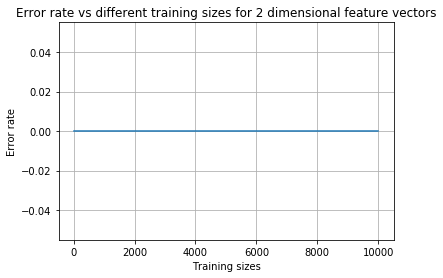

In [32]:
#########################################################################
# Plots of the graphs
# First plot, 4 dimensional for 2 classes
fig = plt.figure()

plt.plot(training_samples, emp_error_4n)
plt.title('Error rate vs different training sizes for 2 dimensional feature vectors')
plt.xlabel('Training sizes')
plt.ylabel('Error rate')
plt.grid()
plt.show()


### 2.5 Study the difference of Euclidean distance and Manhattan distance (https://en.wikipedia.org/wiki/Taxicab_geometry), 
you can choose C=2, varying K. You can choose other parameters based on your own need.

- C = 3, N = 5, varying K

#### manhattan distance:

In [35]:
# Covariance matrices
cov_mats = {}
for i in range(1, 6):
    cov_mats[i] = i * eye(3)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 6), [[0, 0, 0], [3, 0, 9], [4, 5, 1], [3, 6, 2], [7, 3, 6]]):
    mu_vecs[i] = array(j).reshape(3, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 6):
    # generating 80x5 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
train_set = append(train_set, all_samples[3][0:40], axis=0)
train_set = append(train_set, all_samples[4][0:40], axis=0)
train_set = append(train_set, all_samples[5][0:40], axis=0)

test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)
test_set = append(test_set, all_samples[3][40:80], axis=0)
test_set = append(test_set, all_samples[4][40:80], axis=0)
test_set = append(test_set, all_samples[5][40:80], axis=0)

# 40 for training and 40 for testing for each class, thus training data and testing data should have
# size of (40 * 5 = 200, 3) shape, last column is the class column
assert(train_set.shape == (200, 4))
assert(test_set.shape == (200, 4))

X_train = train_set[:, :-1]
X_test = test_set[:, :-1]
y_train = train_set[:, -1]
y_test = test_set[:, -1].astype(integer)

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k, metric="manhattan")
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    accuracy = (num_correct_predictions / y_test.shape[0]) * 100
    print('##############################################################################')
    print(f"when k is {k}  !")
    print('Test set accuracy: %.2f%%' % accuracy)

##############################################################################
when k is 1  !
Test set accuracy: 72.50%
##############################################################################
when k is 2  !
Test set accuracy: 72.00%
##############################################################################
when k is 3  !
Test set accuracy: 74.00%
##############################################################################
when k is 5  !
Test set accuracy: 78.50%
##############################################################################
when k is 10  !
Test set accuracy: 76.50%
##############################################################################
when k is 20  !
Test set accuracy: 78.50%


#### Euclidean distance:

In [36]:
# Covariance matrices
cov_mats = {}
for i in range(1, 6):
    cov_mats[i] = i * eye(3)

# mean vectors
mu_vecs = {}
for i, j in zip(range(1, 6), [[0, 0, 0], [3, 0, 9], [4, 5, 1], [3, 6, 2], [7, 3, 6]]):
    mu_vecs[i] = array(j).reshape(3, 1)

# Generating the random samples
all_samples = {}
for i in range(1, 6):
    # generating 80x5 dimensional arrays with random Gaussian-distributed samples
    class_samples = random.multivariate_normal(mu_vecs[i].ravel(), cov_mats[i], 80)
    # adding class label to 3rd column
    class_samples = append(class_samples, zeros((80, 1))+i, axis=1)
    all_samples[i] = class_samples

# Dividing the samples into training and test datasets
train_set = append(all_samples[1][0:40], all_samples[2][0:40], axis=0)
train_set = append(train_set, all_samples[3][0:40], axis=0)
train_set = append(train_set, all_samples[4][0:40], axis=0)
train_set = append(train_set, all_samples[5][0:40], axis=0)

test_set = append(all_samples[1][40:80], all_samples[2][40:80], axis=0)
test_set = append(test_set, all_samples[3][40:80], axis=0)
test_set = append(test_set, all_samples[4][40:80], axis=0)
test_set = append(test_set, all_samples[5][40:80], axis=0)

# 40 for training and 40 for testing for each class, thus training data and testing data should have
# size of (40 * 5 = 200, 3) shape, last column is the class column
assert(train_set.shape == (200, 4))
assert(test_set.shape == (200, 4))

X_train = train_set[:, :-1]
X_test = test_set[:, :-1]
y_train = train_set[:, -1]
y_test = test_set[:, -1].astype(integer)

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    num_correct_predictions = (y_pred == y_test).sum()
    accuracy = (num_correct_predictions / y_test.shape[0]) * 100
    print('##############################################################################')
    print(f"when k is {k}  !")
    print('Test set accuracy: %.2f%%' % accuracy)

##############################################################################
when k is 1  !
Test set accuracy: 74.50%
##############################################################################
when k is 2  !
Test set accuracy: 72.00%
##############################################################################
when k is 3  !
Test set accuracy: 75.50%
##############################################################################
when k is 5  !
Test set accuracy: 80.00%
##############################################################################
when k is 10  !
Test set accuracy: 77.00%
##############################################################################
when k is 20  !
Test set accuracy: 77.50%
